# Open on colab

In [1]:
#data API youtube documentation:
#https://developers.google.com/youtube/v3/docs

In [2]:
from googleapiclient.discovery import build
from google.colab import files
import pandas as pd
!pip install isodate
import isodate
import seaborn as sns
import matplotlib.pyplot as plt

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.7/41.7 kB 1.2 MB/s eta 0:00:00


In [1]:
from api_keys import api_key

In [3]:
#keys
channel_id = "UCGBpxWJr9FNOcFYA5GkKrMg" #boiler room

#to compare different channels
channel_ids = ['UCnz-ZXXER4jOvuED5trXfEA', #techTFQ
               'UCW8Ews7tdKKkBT6GdtQaXvQ', #stratascratch
               'UCtYLUTtgS3k1Fg4y5tAhLbw', #statquest
               'UCGBpxWJr9FNOcFYA5GkKrMg'  #boiler room
               ]

#creating the youtube service
youtube = build("youtube", "v3",  developerKey=api_key)

In [4]:
## Funtion to get channel statistics
def get_channel_stats(youtube, channel_id):
  
  #this part of code code is taken from https://developers.google.com/youtube/v3/docs/channels/list -> list (by channel ID) -> python code
  request = youtube.channels().list(
            part='snippet,contentDetails,statistics',
            id=channel_id)
  response = request.execute()

  #creating a dictionary where I put all the data i'm interested in
  data = dict(Channel_name = response['items'][0]['snippet']['title'],
              Subscribers = response['items'][0]['statistics']['subscriberCount'],
              Views = response['items'][0]['statistics']['viewCount'],
              Total_videos = response['items'][0]['statistics']['videoCount'],
              Playlist_id= response['items'][0]['contentDetails']['relatedPlaylists']['uploads']
              )

  #return response
  return data

In [5]:
get_channel_stats(youtube, channel_id)

{'Channel_name': 'Boiler Room',
 'Subscribers': '3420000',
 'Views': '1180815859',
 'Total_videos': '8914',
 'Playlist_id': 'UUGBpxWJr9FNOcFYA5GkKrMg'}

In [6]:
## if you want to compare different channels
def get_channel_stats(youtube, channel_ids):
  all_data = []
  request = youtube.channels().list(
            part='snippet,contentDetails,statistics',
            id=','.join(channel_ids))
  
  response = request.execute()

  for i in range(len(response['items'])):
      data = dict(Channel_name = response['items'][i]['snippet']['title'],
                  Subscribers = response['items'][i]['statistics']['subscriberCount'],
                  Views = response['items'][i]['statistics']['viewCount'],
                  Total_videos = response['items'][i]['statistics']['videoCount'],
                  Playlist_id= response['items'][i]['contentDetails']['relatedPlaylists']['uploads']
                  )
      all_data.append(data)

  return all_data

In [7]:
channel_statistics = get_channel_stats(youtube, channel_ids)
channel_data = pd.DataFrame(channel_statistics)
channel_data

,Channel_name,Subscribers,Views,Total_videos,Playlist_id
0,StatQuest with Josh Starmer,922000,48492064,254,UUtYLUTtgS3k1Fg4y5tAhLbw
1,StrataScratch,42000,1361344,152,UUW8Ews7tdKKkBT6GdtQaXvQ
2,techTFQ,194000,9494955,87,UUnz-ZXXER4jOvuED5trXfEA
3,Boiler Room,3420000,1180815859,8914,UUGBpxWJr9FNOcFYA5GkKrMg


In [8]:
channel_data.dtypes

Channel_name    object
Subscribers     object
Views           object
Total_videos    object
Playlist_id     object
dtype: object

In [9]:
#since we have only 'object' type we want integer so:
channel_data['Subscribers'] = pd.to_numeric(channel_data['Subscribers'])
channel_data['Views'] = pd.to_numeric(channel_data['Views'])
channel_data['Total_videos'] = pd.to_numeric(channel_data['Total_videos'])
channel_data.dtypes

Channel_name    object
Subscribers      int64
Views            int64
Total_videos     int64
Playlist_id     object
dtype: object

In [10]:
#get video ids of boiler room:
#https://developers.google.com/youtube/v3/docs/playlistItems/list -> try this method -> expand -> python code -> copy this part
#then select the parameters i want: part and playlistId

playlist_id ='UUGBpxWJr9FNOcFYA5GkKrMg'

def get_video_ids(youtube, playlist_id):

      video_ids = []

      request = youtube.playlistItems().list( #in here you insert all the parameters you need
                part='snippet, contentDetails',
                playlistId=playlist_id,
                maxResults=50,
                )
      response = request.execute()

      for item in response['items']:
          video_ids.append(item['contentDetails']['videoId'])

      next_page_token = response.get('nextPageToken')
      while next_page_token is not None:
            request = youtube.playlistItems().list(
                    part='snippet, contentDetails',
                    playlistId=playlist_id,
                    maxResults=50,
                    pageToken=next_page_token
                    )
            response = request.execute()

            for item in response['items']:
                video_ids.append(item['contentDetails']['videoId'])

            next_page_token = response.get('nextPageToken')
        
      return video_ids

In [11]:
video_ids = get_video_ids(youtube, playlist_id)
len(video_ids)
#but we know that boiler room has uploaded 8710	videos so we need to put the maxResults parameter to 50 but we want all 8000 videos so we need to check also the
#next pages with a token in the function

8810

In [12]:
#Get video statistics

def get_video_details(youtube, video_ids):
    
    all_video_info = []

    for i in range(0, len(video_ids), 50):
        request = youtube.videos().list(
              part='snippet, contentDetails,statistics',
              id=','.join(video_ids[i:i+50])
              )
        response = request.execute()

        for video in response['items']:
            stats_to_keep = {'snippet': ['channelTitle', 'title', 'description', 'tags', 'publishedAt'],
                            'statistics': ['viewCount', 'likeCount', 'commentCount'],
                            'contentDetails': ['duration', 'definition', 'caption']
                            }
            video_info = {}
            video_info['video_id'] = video['id']

            #check
            for k in stats_to_keep.keys():
              for v in stats_to_keep[k]:
                try:
                  video_info[v] = video[k][v]
                except:
                  video_info[v] = None
        
            all_video_info.append(video_info)

    return pd.DataFrame(all_video_info)

In [13]:
video_df = get_video_details(youtube, video_ids)

In [14]:
len(video_df)

8810

In [15]:
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption
0,e_9IC04YUb4,Boiler Room,Boiler Room Uzbekistan: Sublimation | Trailer,Watch in full: https://blrrm.tv/uz-playlist\n\...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04T18:00:14Z,3584,248,2,PT27S,hd,false
1,JMTky3Bw3UY,Boiler Room,Xyarim | Boiler Room Uzbekistan: Sublimation,Xyarim – live from Sublimation in Uzbekistan. ...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04T17:32:10Z,12040,656,81,PT53M19S,hd,false
2,9D-NU-VUT1A,Boiler Room,Sabinē | Boiler Room Uzbekistan: Sublimation,Sabinē – live from Sublimation in Uzbekistan.\...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04T16:30:08Z,13576,482,61,PT1H2M8S,hd,false
3,BoaUfTPklq4,Boiler Room,Mari Breslavets | Boiler Room Uzbekistan: Subl...,Mari Breslavets – live from Sublimation in Uzb...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04T15:38:08Z,7390,359,75,PT52M21S,hd,false
4,KprwAdN87L8,Boiler Room,Josef Tumari (Live) | Boiler Room Uzbekistan: ...,Josef Tumari – live from Sublimation in Uzbeki...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04T13:42:09Z,21799,1184,162,PT50M4S,hd,false


In [16]:
#dataset is ready -> let's move on to the analysis

video_df.isnull().any()

video_id        False
channelTitle    False
title           False
description     False
tags             True
publishedAt     False
viewCount        True
likeCount        True
commentCount     True
duration        False
definition      False
caption         False
dtype: bool

In [17]:
video_df.dtypes

video_id        object
channelTitle    object
title           object
description     object
tags            object
publishedAt     object
viewCount       object
likeCount       object
commentCount    object
duration        object
definition      object
caption         object
dtype: object

In [18]:
numeric_cols = ['viewCount', 'likeCount', 'commentCount']
video_df[numeric_cols] = video_df[numeric_cols].apply(pd.to_numeric, errors = 'coerce', axis =1)

In [19]:
#re-format dates
video_df['publishedAt'] = video_df['publishedAt'].apply(lambda x: x.split("T")[0])

In [20]:
#convert duration column to numeric
video_df['durationSecs'] = video_df['duration'].apply(lambda x: isodate.parse_duration(x))
video_df['durationSecs'] = video_df['durationSecs'].astype('timedelta64[s]')
video_df[['durationSecs', 'duration']]

,durationSecs,duration
0,27.0,PT27S
1,3199.0,PT53M19S
2,3728.0,PT1H2M8S
3,3141.0,PT52M21S
4,3004.0,PT50M4S
...,...,...
8805,6236.0,PT1H43M56S
8806,2056.0,PT34M16S
8807,2834.0,PT47M14S
8808,1892.0,PT31M32S


In [21]:
#add tag count
video_df['tagCount'] = video_df['tags'].apply(lambda x: 0 if x is None else len(x))
video_df

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,durationSecs,tagCount
0,e_9IC04YUb4,Boiler Room,Boiler Room Uzbekistan: Sublimation | Trailer,Watch in full: https://blrrm.tv/uz-playlist\n\...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04,3584.0,248.0,2.0,PT27S,hd,false,27.0,9
1,JMTky3Bw3UY,Boiler Room,Xyarim | Boiler Room Uzbekistan: Sublimation,Xyarim – live from Sublimation in Uzbekistan. ...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04,12040.0,656.0,81.0,PT53M19S,hd,false,3199.0,9
2,9D-NU-VUT1A,Boiler Room,Sabinē | Boiler Room Uzbekistan: Sublimation,Sabinē – live from Sublimation in Uzbekistan.\...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04,13576.0,482.0,61.0,PT1H2M8S,hd,false,3728.0,9
3,BoaUfTPklq4,Boiler Room,Mari Breslavets | Boiler Room Uzbekistan: Subl...,Mari Breslavets – live from Sublimation in Uzb...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04,7390.0,359.0,75.0,PT52M21S,hd,false,3141.0,9
4,KprwAdN87L8,Boiler Room,Josef Tumari (Live) | Boiler Room Uzbekistan: ...,Josef Tumari – live from Sublimation in Uzbeki...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04,21799.0,1184.0,162.0,PT50M4S,hd,false,3004.0,9
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8805,jnGtXnpZYDY,Boiler Room,Jamie xx b2b Caribou Boiler Room London DJ set,► Two of a kind. Watch Caribou and Jamie xx go...,"[Jamie XX, Caribou, Dan Snaith, The XX, Radioh...",2012-06-01,1094358.0,7773.0,1068.0,PT1H43M56S,sd,false,6236.0,23
8806,7pD4Men1UrA,Boiler Room,Carl Craig Boiler Room London Live Set,► Download audio: http://blrrm.tv/br-app ► Mor...,"[Carl Craig, Carl Craig Live, Carl Craig 69 Li...",2012-06-01,267407.0,1248.0,282.0,PT34M16S,sd,false,2056.0,30
8807,0w755tKL5L8,Boiler Room,Lunice Boiler Room London DJ set,► Download audio: http://blrrm.tv/br-app ► Mor...,"[Lunice, Boiler Room, Lucky Me, Lunice mix, Lu...",2012-06-01,166083.0,1265.0,583.0,PT47M14S,sd,false,2834.0,24
8808,qt-ohn5C3kU,Boiler Room,Thom Yorke Boiler Room London DJ set,"► Yep. It's *that* Boiler Room set by the man,...","[Boiler Room, Thom Yorke, Radiohead, The King ...",2012-06-01,1961241.0,24532.0,3701.0,PT31M32S,sd,false,1892.0,37


In [22]:
#add minutes column:
video_df['minutes'] = round(video_df['durationSecs']/60, 4)
video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,durationSecs,tagCount,minutes
0,e_9IC04YUb4,Boiler Room,Boiler Room Uzbekistan: Sublimation | Trailer,Watch in full: https://blrrm.tv/uz-playlist\n\...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04,3584.0,248.0,2.0,PT27S,hd,false,27.0,9,0.4500
1,JMTky3Bw3UY,Boiler Room,Xyarim | Boiler Room Uzbekistan: Sublimation,Xyarim – live from Sublimation in Uzbekistan. ...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04,12040.0,656.0,81.0,PT53M19S,hd,false,3199.0,9,53.3167
2,9D-NU-VUT1A,Boiler Room,Sabinē | Boiler Room Uzbekistan: Sublimation,Sabinē – live from Sublimation in Uzbekistan.\...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04,13576.0,482.0,61.0,PT1H2M8S,hd,false,3728.0,9,62.1333
3,BoaUfTPklq4,Boiler Room,Mari Breslavets | Boiler Room Uzbekistan: Subl...,Mari Breslavets – live from Sublimation in Uzb...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04,7390.0,359.0,75.0,PT52M21S,hd,false,3141.0,9,52.3500
4,KprwAdN87L8,Boiler Room,Josef Tumari (Live) | Boiler Room Uzbekistan: ...,Josef Tumari – live from Sublimation in Uzbeki...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04,21799.0,1184.0,162.0,PT50M4S,hd,false,3004.0,9,50.0667


In [23]:
#save dataframe in local pc
#video_df.to_csv('BRvideos.csv', encoding = 'utf-8-sig', header=True, index=True) 
#files.download('BRvideos.csv')

In [24]:
#EDA

video_df.head()

,video_id,channelTitle,title,description,tags,publishedAt,viewCount,likeCount,commentCount,duration,definition,caption,durationSecs,tagCount,minutes
0,e_9IC04YUb4,Boiler Room,Boiler Room Uzbekistan: Sublimation | Trailer,Watch in full: https://blrrm.tv/uz-playlist\n\...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04,3584.0,248.0,2.0,PT27S,hd,false,27.0,9,0.4500
1,JMTky3Bw3UY,Boiler Room,Xyarim | Boiler Room Uzbekistan: Sublimation,Xyarim – live from Sublimation in Uzbekistan. ...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04,12040.0,656.0,81.0,PT53M19S,hd,false,3199.0,9,53.3167
2,9D-NU-VUT1A,Boiler Room,Sabinē | Boiler Room Uzbekistan: Sublimation,Sabinē – live from Sublimation in Uzbekistan.\...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04,13576.0,482.0,61.0,PT1H2M8S,hd,false,3728.0,9,62.1333
3,BoaUfTPklq4,Boiler Room,Mari Breslavets | Boiler Room Uzbekistan: Subl...,Mari Breslavets – live from Sublimation in Uzb...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04,7390.0,359.0,75.0,PT52M21S,hd,false,3141.0,9,52.3500
4,KprwAdN87L8,Boiler Room,Josef Tumari (Live) | Boiler Room Uzbekistan: ...,Josef Tumari – live from Sublimation in Uzbeki...,"[Boiler Room, House, techno, Bass, dance music...",2023-05-04,21799.0,1184.0,162.0,PT50M4S,hd,false,3004.0,9,50.0667


In [25]:
video_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8810 entries, 0 to 8809
Data columns (total 15 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   video_id      8810 non-null   object 
 1   channelTitle  8810 non-null   object 
 2   title         8810 non-null   object 
 3   description   8810 non-null   object 
 4   tags          7708 non-null   object 
 5   publishedAt   8810 non-null   object 
 6   viewCount     8691 non-null   float64
 7   likeCount     7975 non-null   float64
 8   commentCount  8752 non-null   float64
 9   duration      8810 non-null   object 
 10  definition    8810 non-null   object 
 11  caption       8810 non-null   object 
 12  durationSecs  8810 non-null   float64
 13  tagCount      8810 non-null   int64  
 14  minutes       8810 non-null   float64
dtypes: float64(5), int64(1), object(9)
memory usage: 1.0+ MB


In [26]:
video_df_numeric = video_df[['viewCount', 'likeCount', 'commentCount', 'durationSecs', 'tagCount']]
video_df_numeric

,viewCount,likeCount,commentCount,durationSecs,tagCount
0,3584.0,248.0,2.0,27.0,9
1,12040.0,656.0,81.0,3199.0,9
2,13576.0,482.0,61.0,3728.0,9
3,7390.0,359.0,75.0,3141.0,9
4,21799.0,1184.0,162.0,3004.0,9
...,...,...,...,...,...
8805,1094358.0,7773.0,1068.0,6236.0,23
8806,267407.0,1248.0,282.0,2056.0,30
8807,166083.0,1265.0,583.0,2834.0,24
8808,1961241.0,24532.0,3701.0,1892.0,37


In [27]:
round(video_df.describe(),2)

,viewCount,likeCount,commentCount,durationSecs,tagCount,minutes
count,8691.00,7975.00,8752.00,8810.00,8810.00,8810.00
mean,134242.57,1665.73,118.68,2781.83,14.51,46.36
std,1094108.86,9559.67,495.88,1815.12,13.21,30.25
min,1.00,0.00,0.00,9.00,0.00,0.15
25%,8655.50,120.00,11.00,1783.00,4.00,29.72
50%,19763.00,299.00,30.00,2946.00,9.00,49.10
75%,63504.00,887.50,88.00,3610.00,25.00,60.17
max,60923496.00,372554.00,18446.00,42902.00,63.00,715.03


In [28]:
video_df.isnull().sum()

video_id           0
channelTitle       0
title              0
description        0
tags            1102
publishedAt        0
viewCount        119
likeCount        835
commentCount      58
duration           0
definition         0
caption            0
durationSecs       0
tagCount           0
minutes            0
dtype: int64

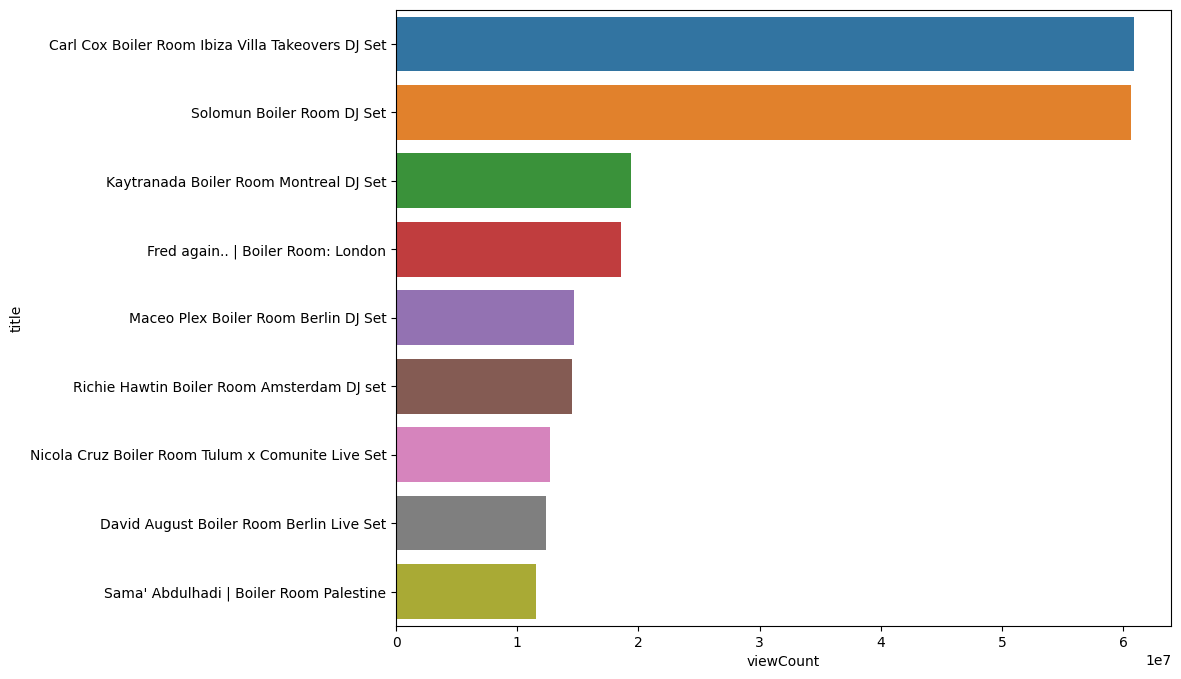

In [29]:
#best performing videos:
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='viewCount', y='title', data = video_df.sort_values('viewCount', ascending=False)[0:9])

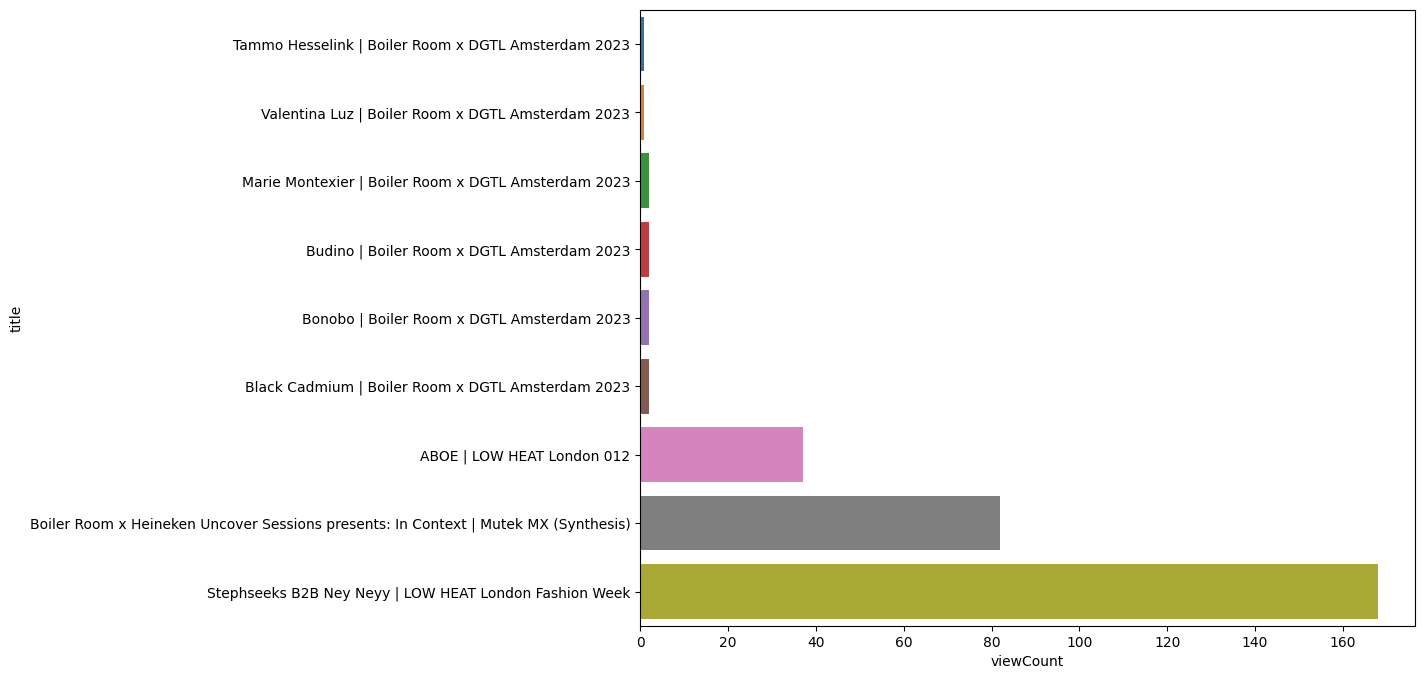

In [30]:
plt.figure(figsize=(10, 8))
ax = sns.barplot(x='viewCount', y='title', data = video_df.sort_values('viewCount', ascending=True)[0:9])

<Axes: >

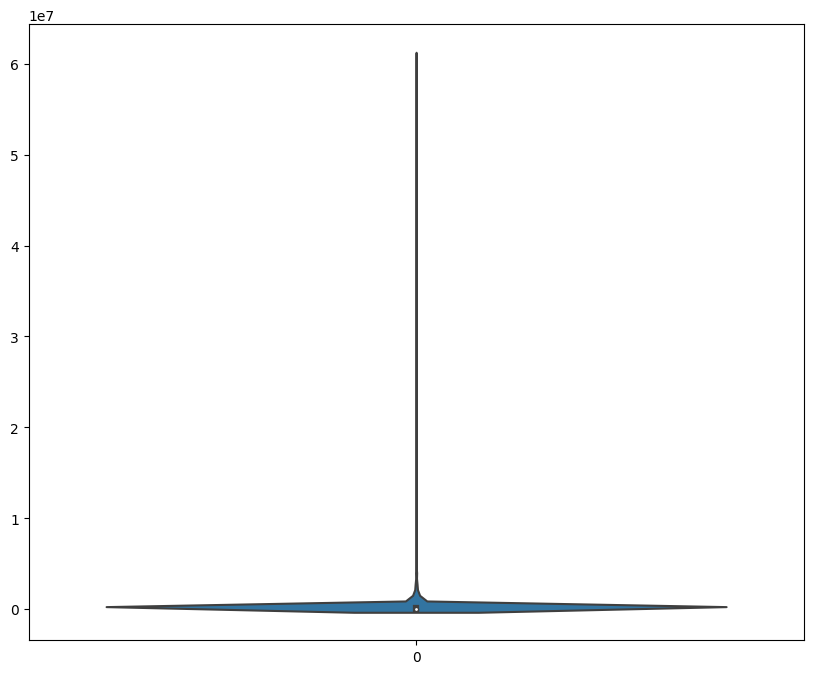

In [32]:
#view distribution per video, useful also to compare different channels
plt.figure(figsize=(10, 8))
sns.violinplot(video_df['viewCount'])

#most of his videos have aproximately 100.000 views with many outliers with millions of views

In [33]:
#in fact
video_df['viewCount'].mean()

134242.57185594292

<ipython-input-34-68e6d7bc1e91>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(video_df.corr(), square=True, annot=True)


<Axes: >

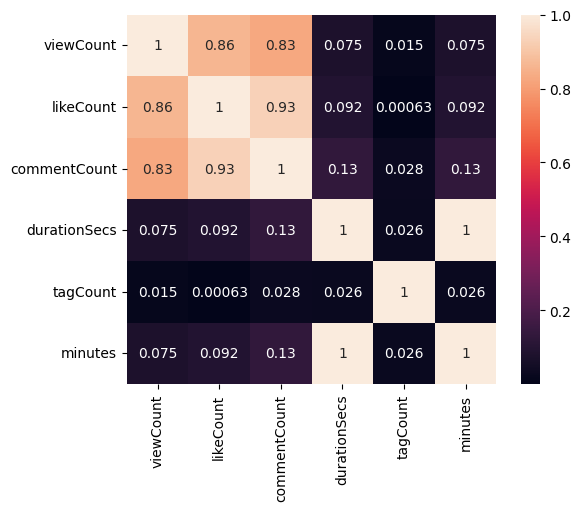

In [34]:
sns.heatmap(video_df.corr(), square=True, annot=True)
#high correlation between views, comments and likes
#we could've thought that the tag count would be coorelated with the view and like count (since maybe the channel wanted to "pump up" a video to make it more popular)
#but this is not the case as we can see from the plot

<Axes: xlabel='likeCount', ylabel='viewCount'>

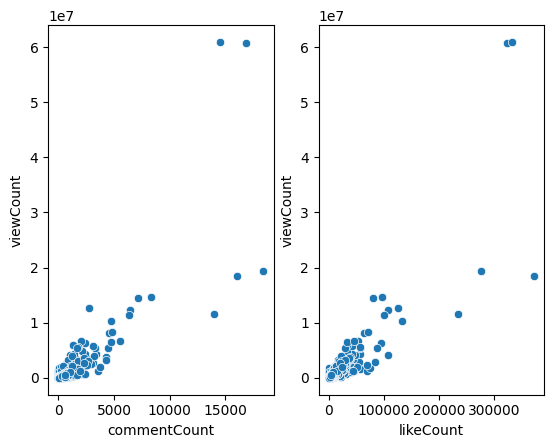

In [35]:
#views vs likes, comments high correlation
fig, ax =plt.subplots(1,2)
sns.scatterplot(data = video_df, x='commentCount', y ='viewCount', ax =ax[0])
sns.scatterplot(data = video_df, x='likeCount', y ='viewCount', ax =ax[1])

#positive correlation -> the more views, the more comments and likes

<Axes: xlabel='durationSecs', ylabel='Count'>

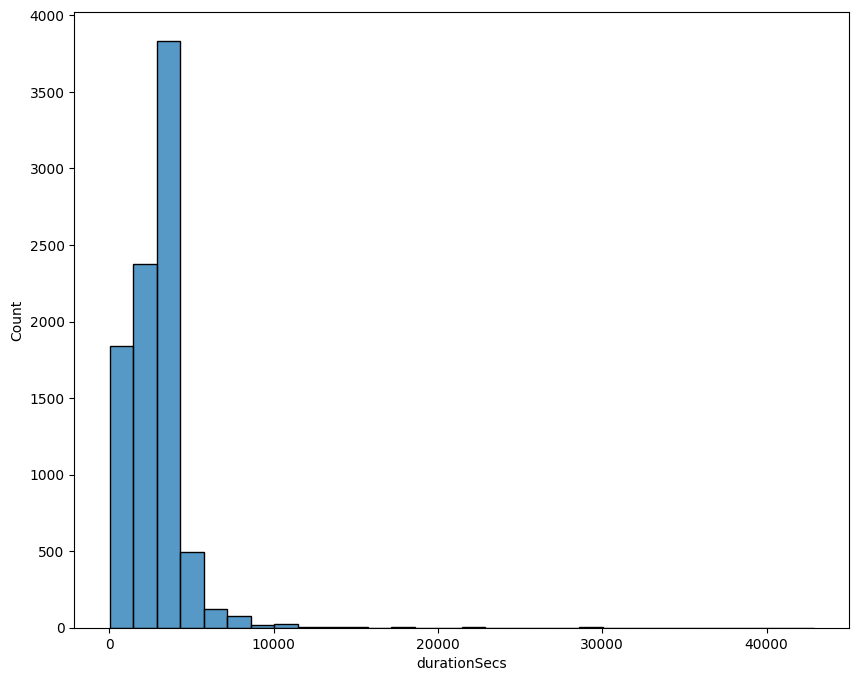

In [36]:
#video duration
plt.figure(figsize=(10, 8))
sns.histplot(data=video_df, x='durationSecs', bins=30)

<Axes: xlabel='minutes', ylabel='Count'>

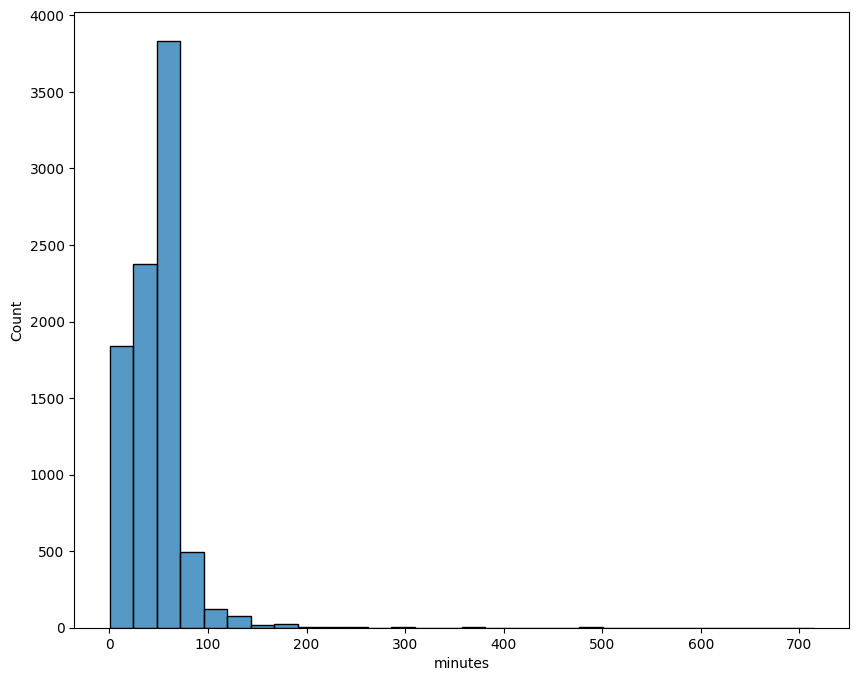

In [37]:
#obviously the distribution of the duration of the seconds is identical to the distribution of the distribution of the minutes, but this is more clear in terms of indices
plt.figure(figsize=(10, 8))
sns.histplot(data=video_df, x='minutes', bins=30)

In [38]:
#in fact the mean it around 3000 seconds per video:
video_df["durationSecs"].mean()

2781.828149829739

In [39]:
 #which in minutes is:
 round((video_df['durationSecs'].mean())/60, 4)

46.3638

In [40]:
#this is an outlier
#nearly 12 hours long video
video_df.loc[video_df['minutes'].idxmax()]

video_id                                              UxFq-lUv9eU
channelTitle                                          Boiler Room
title                                                 Sangoplasmo
description     http://boilerroom.tv/session/sangoplasmo/  San...
tags                                                         None
publishedAt                                            2015-02-27
viewCount                                                     NaN
likeCount                                                     NaN
commentCount                                                  NaN
duration                                               PT11H55M2S
definition                                                     hd
caption                                                     false
durationSecs                                              42902.0
tagCount                                                        0
minutes                                                  715.0333
Name: 6300

In [ ]:
print(f'Sangoplasmo Boiler Room video was {round(715.0333/60, 3)} hours long.')

Sangoplasmo Boiler Room video was 11.917 hours long.
